# Processing data

In [19]:
#!pip install rdkit xgboost numpy pandas scikit-learn matplotlib seaborn smogn smogn imblearn joblib
%pip install rdkit xgboost numpy pandas scikit-learn matplot lib seaborn smogn imblearn joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, zero_one_loss, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import smogn
from imblearn.over_sampling import SMOTE
import joblib
from imblearn.combine import SMOTETomek

from collections import Counter

In [21]:
%pip install gdown
import gdown
url_csv = "https://drive.google.com/drive/folders/19WknU_bI2AD_o124sV48yVDzGicPGmGM?usp=drive_link"
url_embeddings = "https://drive.google.com/drive/folders/1Eop8xnD8XPh5nU0omBgoQ84l7u2W_KQZ?usp=sharing"
gdown.download_folder(url_csv, quiet=True)
gdown.download_folder(url_embeddings, quiet=True)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


['c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\all_seqs.pkl',
 'c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\base_seq.pkl',
 'c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\global_embeddings_map.pkl',
 'c:\\Users\\misse\\Projects\\pharmahacks_25\\pharmahacks-25\\embeddings\\global_embeddings_max_length.npy']

In [22]:
# Load data
table1 = pd.read_csv('test_data/table-1.csv')
table2 = pd.read_csv('test_data/table-2.csv')
table3 = pd.read_csv('test_data/table-3.csv')

with open('embeddings/all_seqs.pkl', 'rb') as f:
  all_seqs = pickle.load(f)

with open('embeddings/base_seq.pkl', 'rb') as f:
  base_seq = pickle.load(f)

global_embeddings = np.load('embeddings/global_embeddings_max_length.npy')

with open('embeddings/global_embeddings_map.pkl', 'rb') as f:
  global_embeddings_map = pickle.load(f)

# ensure embeddings correspond to correct kinases
kinase_ids = list(global_embeddings_map.keys())
kinase_embeddings = {kinase: global_embeddings[i] for i, kinase in enumerate(kinase_ids)}

print(kinase_embeddings)

{'AAK1': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        1.0579960e-05,  5.8259507e-06,  9.1596256e-08],
      shape=(15599,), dtype=float32), 'ABL1(E255K)-phosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.5299056e-06,  1.7210321e-05,  2.3178212e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317I)-nonphosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.2921305e-06,  1.6433652e-05,  2.4846892e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317I)-phosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.2921305e-06,  1.6433652e-05,  2.4846892e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317L)-nonphosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
        5.4387606e-06,  1.6194173e-05,  2.3473470e-07],
      shape=(15599,), dtype=float32), 'ABL1(F317L)-phosphorylated': array([-4.2408835e-03,  3.2960442e-03, -1.5650194e-02, ...,
     

In [23]:
# Apply PCA to embeddings
embeddings = np.array(list(kinase_embeddings.values()))

# standardize embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# pca
pca = PCA(n_components=0.95)
embeddings_pca = pca.fit_transform(embeddings_scaled)

# convert to dataframe
embeddings_df = pd.DataFrame(embeddings_pca, index=kinase_ids)
embeddings_df_reset = embeddings_df.reset_index()
embeddings_df_reset.rename(columns={'index': 'Kinase'}, inplace=True)
print(embeddings_df_reset.head())
print(embeddings_df_reset.shape)

                          Kinase          0          1          2          3  \
0                           AAK1  -0.813679 -29.187014  13.221566  21.716599   
1     ABL1(E255K)-phosphorylated  12.826459  43.214863  13.407912  21.331444   
2  ABL1(F317I)-nonphosphorylated  13.478254  42.953426  13.528316  21.925327   
3     ABL1(F317I)-phosphorylated  13.478270  42.953411  13.528316  21.925386   
4  ABL1(F317L)-nonphosphorylated  12.943295  42.563278  13.421924  22.069048   

           4          5          6         7          8  ...       123  \
0  21.009573   0.054794 -10.262155 -8.797714  -7.910841  ... -1.554923   
1  44.701019  22.857103   8.390306 -2.437561 -23.676567  ... -0.421884   
2  44.929493  22.960983   8.603175 -2.175603 -23.007704  ... -0.432414   
3  44.929520  22.961037   8.603200 -2.175596 -23.007742  ... -0.432415   
4  45.136337  22.860001   8.589225 -2.048869 -23.198624  ... -0.317752   

        124       125       126       127       128       129       130  \

In [24]:
# extract compound names
compound_columns = table3.columns[3:]
print(compound_columns)
print(compound_columns.shape)

Index(['AMG-706', 'BIBF-1120 (derivative)', 'CI-1040', 'GSK-461364A', 'PI-103',
       'SKI-606', 'Sorafenib', 'SU-14813', 'Sunitinib', 'TG-100-115',
       'VX-680/MK-0457', 'VX-745'],
      dtype='object')
(12,)


In [25]:
# reshape table3 to long format
kinase_compound_kd = pd.melt(
    table3,
    id_vars=['Accession Number', 'Entrez Gene Symbol', 'Kinase'],
    value_vars=compound_columns,
    var_name='Compound',
    value_name='Kd'
)
# merge the embeddings
merged_embeddings_kd = pd.merge(
    kinase_compound_kd,
    embeddings_df_reset,
    on='Kinase',
    how='left'
)

print(merged_embeddings_kd.head(10))

  Accession Number Entrez Gene Symbol                         Kinase Compound  \
0      NP_055726.3               AAK1                           AAK1  AMG-706   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated  AMG-706   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated  AMG-706   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated  AMG-706   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated  AMG-706   
5      NP_005148.2               ABL1     ABL1(F317L)-phosphorylated  AMG-706   
6      NP_005148.2               ABL1  ABL1(H396P)-nonphosphorylated  AMG-706   
7      NP_005148.2               ABL1     ABL1(H396P)-phosphorylated  AMG-706   
8      NP_005148.2               ABL1     ABL1(M351T)-phosphorylated  AMG-706   
9      NP_005148.2               ABL1  ABL1(Q252H)-nonphosphorylated  AMG-706   

        Kd          0          1          2          3          4  ...  \
0  10001.0  -0.813679 -29.187014  

In [26]:
# Convert chemical structures to fingerprints

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
      generator = GetMorganGenerator(radius=2, fpSize=2048)
      fp = generator.GetFingerprint(mol)
      arr = np.zeros((512,), dtype=int)
      DataStructs.ConvertToNumpyArray(fp, arr)
      return arr
    else:
      return None # invalid SMILES

table2['Fingerprint'] = table2['SMILES'].apply(smiles_to_fingerprint)
table2 = table2.dropna(subset=['Fingerprint'])

# convert fingerprint column to NumPy array
X_fingerprints = np.array(table2['Fingerprint'].tolist())

print(table2.head())

                 Compound                                             SMILES  \
0                 AMG-706  CC1(CNC2=C1C=CC(=C2)NC(=O)C3=C(N=CC=C3)NCC4=CC...   
1  BIBF-1120 (derivative)  O=C1NC2=CC(C(OC)=O)=CC=C2/C1=C(NC3=CC=C(N(C(CN...   
2                 CI-1040  C1CC1CONC(=O)C2=C(C(=C(C=C2)F)F)NC3=C(C=C(C=C3...   
3             GSK-461364A  CC(C1=CC=CC=C1C(F)(F)F)OC2=C(SC(=C2)N3C=NC4=C3...   
4                  PI-103  C1COCCN1C2=NC(=NC3=C2OC4=C3C=CC=N4)C5=CC(=CC=C5)O   

  Binding Mode (based on ABL1-phos. vs. -nonphos affinity)  S(300nM)  \
0                                            Type II          0.0389   
1                                             Type I          0.2927   
2                                       undetermined          0.0026   
3                                       undetermined          0.0155   
4                                       undetermined          0.0207   

   S(3000nM)                                        Fingerprint  
0     0.0777  [0, 0,

In [27]:
# merge table 2 with table 3 data
binding_data = merged_embeddings_kd.merge(table2[['Compound', 'Fingerprint']], on='Compound', how='left')

# encode the kinase/compound pairs
le_kinase = LabelEncoder()
le_compound = LabelEncoder()

binding_data["Kinase_encoded"] = le_kinase.fit_transform(binding_data["Kinase"])
binding_data["Compound_encoded"] = le_compound.fit_transform(binding_data["Compound"])

# drop 10001
# binding_data = binding_data[binding_data['Kd'] < 10001]

# convert fingerprint column to NumPy array

print(binding_data.head())
# print(binding_data['Kd'].describe())
# print(binding_data.describe())

  Accession Number Entrez Gene Symbol                         Kinase Compound  \
0      NP_055726.3               AAK1                           AAK1  AMG-706   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated  AMG-706   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated  AMG-706   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated  AMG-706   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated  AMG-706   

        Kd          0          1          2          3          4  ...  \
0  10001.0  -0.813679 -29.187014  13.221566  21.716599  21.009573  ...   
1  10001.0  12.826459  43.214863  13.407912  21.331444  44.701019  ...   
2   4000.0  13.478254  42.953426  13.528316  21.925327  44.929493  ...   
3  10001.0  13.478270  42.953411  13.528316  21.925386  44.929520  ...   
4    910.0  12.943295  42.563278  13.421924  22.069048  45.136337  ...   

        126       127       128       129       130       131       

## Dataframe for 300nM categorization task

In [28]:
def categorize_kd_300(kd):
    if kd < 300:
        return 0
    else:
        return 1
    
binding_data_300 = binding_data.copy()

# Apply categories to copy
binding_data_300['Kd_category'] = binding_data_300['Kd'].apply(categorize_kd_300)
print(binding_data_300.head())

  Accession Number Entrez Gene Symbol                         Kinase Compound  \
0      NP_055726.3               AAK1                           AAK1  AMG-706   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated  AMG-706   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated  AMG-706   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated  AMG-706   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated  AMG-706   

        Kd          0          1          2          3          4  ...  \
0  10001.0  -0.813679 -29.187014  13.221566  21.716599  21.009573  ...   
1  10001.0  12.826459  43.214863  13.407912  21.331444  44.701019  ...   
2   4000.0  13.478254  42.953426  13.528316  21.925327  44.929493  ...   
3  10001.0  13.478270  42.953411  13.528316  21.925386  44.929520  ...   
4    910.0  12.943295  42.563278  13.421924  22.069048  45.136337  ...   

        127       128       129       130       131       132  \
0  

In [29]:
fingerprints_300 = np.array(binding_data['Fingerprint'].tolist())

embeddings_300 = np.array(binding_data[[i for i in range(133)]])

X_300= np.hstack((fingerprints_300, embeddings_300))
y_300 = binding_data_300['Kd_category'].values

## Dataframe for categorization task

In [30]:
def categorize_kd_3000(kd):
    if kd < 3000:
        return 0
    else:
        return 1
    
binding_data_3000 = binding_data.copy()

# Apply categories to copy
binding_data_3000['Kd_category'] = binding_data_300['Kd'].apply(categorize_kd_3000)
print(binding_data_3000.head())

  Accession Number Entrez Gene Symbol                         Kinase Compound  \
0      NP_055726.3               AAK1                           AAK1  AMG-706   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated  AMG-706   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated  AMG-706   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated  AMG-706   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated  AMG-706   

        Kd          0          1          2          3          4  ...  \
0  10001.0  -0.813679 -29.187014  13.221566  21.716599  21.009573  ...   
1  10001.0  12.826459  43.214863  13.407912  21.331444  44.701019  ...   
2   4000.0  13.478254  42.953426  13.528316  21.925327  44.929493  ...   
3  10001.0  13.478270  42.953411  13.528316  21.925386  44.929520  ...   
4    910.0  12.943295  42.563278  13.421924  22.069048  45.136337  ...   

        127       128       129       130       131       132  \
0  

In [31]:
fingerprints_3000 = np.array(binding_data['Fingerprint'].tolist())

embeddings_3000 = np.array(binding_data[[i for i in range(133)]])

X_3000 = np.hstack((fingerprints_3000, embeddings_3000))
y_3000 = binding_data_3000['Kd_category'].values

## Models

In [32]:
clf_300 = joblib.load('models/300_kd_classifier_weight.pkl')
clf_3000 = joblib.load('models/3000_kd_classifier_weight.pkl')

In [33]:
dmatrix_300 = xgb.DMatrix(X_300)
dmatrix_3000 = xgb.DMatrix(X_3000)

predictions_300 = clf_300.predict(dmatrix_300)
predictions_3000 = clf_3000.predict(dmatrix_3000)

print(predictions_300)
print(predictions_3000)

[0.7843628  0.5378856  0.74722385 ... 0.45232043 0.959532   0.9808352 ]
[0.6689945  0.4683529  0.6683868  ... 0.26033917 0.82165873 0.9736665 ]


### 300nM report

Accuracy: 0.8281
              precision    recall  f1-score   support

      <300nM       0.33      0.32      0.32       677
      >300nM       0.90      0.90      0.90      4627

    accuracy                           0.83      5304
   macro avg       0.61      0.61      0.61      5304
weighted avg       0.83      0.83      0.83      5304



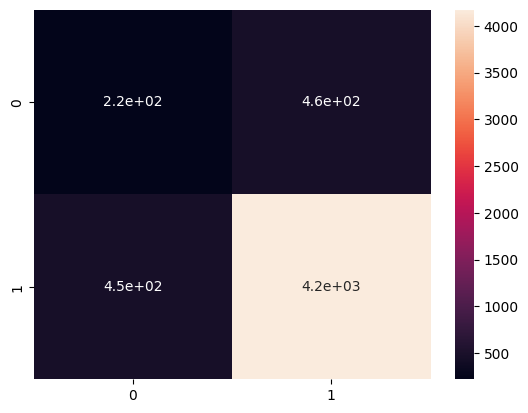

In [37]:
y_pred_bin_300 = (predictions_300 > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_300, y_pred_bin_300)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report (300nM)
print(classification_report(y_300, y_pred_bin_300, target_names=["<300nM", ">300nM"]))
cf_matrix = confusion_matrix(y_300, y_pred_bin_300)
sns.heatmap(cf_matrix, annot=True)
zero_one_loss = (y_pred_bin_300 != y_300).mean()


In [ ]:
def label_to_category(label):
  if label == 0:
      return "<3000nM"
  else:
      return ">3000nM"
  
chosen_threshold = 0.4

y_pred_bin = (y_pred_bin_300 > chosen_threshold).astype(int)
predicted_categories = [label_to_category(label) for label in y_pred_bin]

results_df = pd.DataFrame({
    'Kinase': binding_data['Kinase'].iloc[indices_test].values,
    'Compound': binding_data['Compound'].iloc[indices_test].values,
    'Predicted_Kd_Category': predicted_categories
})

results_df.to_csv('3000_kd_category.csv', index=False)

### 3000nM report

Accuracy: 0.7577
              precision    recall  f1-score   support

     <3000nM       0.64      0.19      0.29      1403
     >3000nM       0.77      0.96      0.85      3901

    accuracy                           0.76      5304
   macro avg       0.70      0.58      0.57      5304
weighted avg       0.73      0.76      0.71      5304



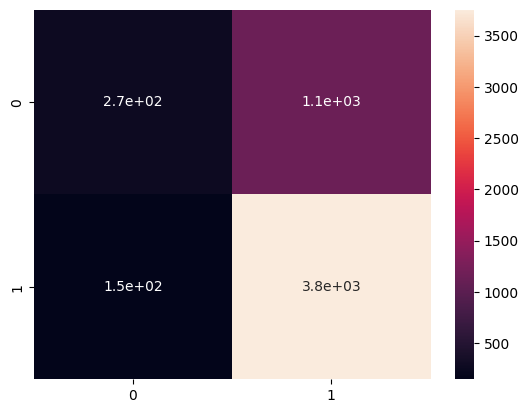

In [41]:
y_pred_bin_3000 = (predictions_3000 > 0.3).astype(int)

# Accuracy
accuracy = accuracy_score(y_3000, y_pred_bin_3000)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report (300nM)
print(classification_report(y_3000, y_pred_bin_3000, target_names=["<3000nM", ">3000nM"]))
cf_matrix = confusion_matrix(y_3000, y_pred_bin_3000)
sns.heatmap(cf_matrix, annot=True)
zero_one_loss = (y_pred_bin_3000 != y_3000).mean()


## Saving specificity scores

In [42]:
def label_to_category_300(label):
    if label == 0:
        return "<300nM"
    else:
        return ">300nM"

def label_to_category_3000(label):
    if label == 0:
        return "<300nM"
    else:
        return ">300nM"

predicted_categories_300 = [label_to_category_300(label) for label in y_pred_bin_300]
predicted_categories_3000 = [label_to_category_3000(label) for label in y_pred_bin_3000]


In [44]:
results_df_300 = pd.DataFrame({
    'Kinase': binding_data_300['Kinase'].values,
    'Compound': binding_data_300['Compound'].values,
    'Predicted_Kd_Category': predicted_categories_300
})

results_df_3000 = pd.DataFrame({
    'Kinase': binding_data_300['Kinase'].values,
    'Compound': binding_data_300['Compound'].values,
    'Predicted_Kd_Category': predicted_categories_3000
})

results_df_300.to_csv('300_kd_category.csv', index=False)
results_df_3000.to_csv('3000_kd_category.csv', index=False)